In [ ]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from dotenv import load_dotenv
from PyPDF2 import PdfReader
import os

load_dotenv()

llm = ChatGroq(model="llama-3.3-70b-versatile", api_key=os.getenv("GROQ_API_KEY"))

llm.invoke("Hello, how are you?")

In [ ]:
from typing_extensions import TypedDict

class State(TypedDict):
    application: str          # Orijinal başvuru metni
    cv_text: str              # PDF'den çıkarılan CV metni
    job_description: str      # İş tanımı
    experience_level: str     # Entry-level / Mid-level / Senior-level
    skill_match: str          # Match / No Match
    match_score: float        # 0-100 arası uyumluluk puanı
    reasoning: str            # LLM'in karar gerekçesi
    response: str             # Nihai karar metni

In [ ]:
def extract_text_from_pdf(pdf_path: str) -> str:
    """PDF dosyasından metin çıkarır ve döndürür."""
    reader = PdfReader(pdf_path)
    text = ""
    for page in reader.pages:
        page_text = page.extract_text()
        if page_text:
            text += page_text + "\n"
    return text.strip()

print("PDF extraction function ready!")

In [ ]:
import re

def categorize_experience(state: State) -> State:
    print("\nCategorizing the experience level of candidate : ")
    prompt = ChatPromptTemplate.from_template(
       "Respond with ONLY one of these three words: 'Entry-level', 'Mid-level', or 'Senior-level'. "
       "Candidate CV: {cv_text}"
    )
    chain = prompt | llm
    raw = chain.invoke({"cv_text": state["cv_text"]}).content
    # Normalize
    if "Senior" in raw:
        experience_level = "Senior-level"
    elif "Mid" in raw:
        experience_level = "Mid-level"
    else:
        experience_level = "Entry-level"
    print(f"Experience Level : {experience_level}")
    return {"experience_level": experience_level}

def assess_skillset(state: State) -> State:
    print("\nAssessing the skillset of candidate : ")
    prompt = ChatPromptTemplate.from_template(
        "Evaluate the candidate's CV against the job description.\n"
        "Respond in EXACTLY this format (nothing else):\n"
        "MATCH_STATUS: Match or No Match\n"
        "SCORE: a number between 0-100\n"
        "REASONING: one sentence explanation\n\n"
        "Job Description: {job_description}\n"
        "Candidate CV: {cv_text}"
    )
    chain = prompt | llm
    raw = chain.invoke({
        "job_description": state["job_description"],
        "cv_text": state["cv_text"]
    }).content

    # Parse MATCH_STATUS
    if "No Match" in raw:
        skill_match = "No Match"
    elif "Match" in raw:
        skill_match = "Match"
    else:
        skill_match = raw.strip()

    # Parse SCORE
    score_match = re.search(r'SCORE:\s*(\d+)', raw)
    match_score = float(score_match.group(1)) if score_match else 0.0

    # Parse REASONING
    reasoning_match = re.search(r'REASONING:\s*(.+)', raw)
    reasoning = reasoning_match.group(1).strip() if reasoning_match else "No reasoning provided."

    print(f"Skill Match : {skill_match}")
    print(f"Match Score : {match_score}/100")
    print(f"Reasoning   : {reasoning}")
    return {"skill_match": skill_match, "match_score": match_score, "reasoning": reasoning}

def schedule_hr_interview(state: State) -> State:
    print("\nScheduling the interview : ")
    return {"response": f"Candidate shortlisted for HR interview. Score: {state['match_score']}/100. {state['reasoning']}"}

def escalate_to_recruiter(state: State) -> State:
    print("Escalating to recruiter")
    return {"response": f"Senior-level candidate doesn't match job skills. Score: {state['match_score']}/100. {state['reasoning']}"}

def reject_application(state: State) -> State:
    print("Sending rejection email")
    return {"response": f"Candidate rejected. Score: {state['match_score']}/100. {state['reasoning']}"}

In [ ]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(State)

# Node'ları ekle
workflow.add_node("categorize_experience", categorize_experience)
workflow.add_node("assess_skillset", assess_skillset)
workflow.add_node("schedule_hr_interview", schedule_hr_interview)
workflow.add_node("escalate_to_recruiter", escalate_to_recruiter)
workflow.add_node("reject_application", reject_application)

# Routing fonksiyonu
def route_app(state: State):
    if state["skill_match"].strip() == "Match":        
        return "schedule_hr_interview"
    elif "Senior" in state["experience_level"]:         
        return "escalate_to_recruiter"
    else:
        return "reject_application"

# Edge'leri ekle
workflow.add_edge(START, "categorize_experience")
workflow.add_edge("categorize_experience", "assess_skillset")
workflow.add_conditional_edges("assess_skillset", route_app)
workflow.add_edge("schedule_hr_interview", END)
workflow.add_edge("escalate_to_recruiter", END)
workflow.add_edge("reject_application", END)

app = workflow.compile()
print("Graph compiled successfully!")

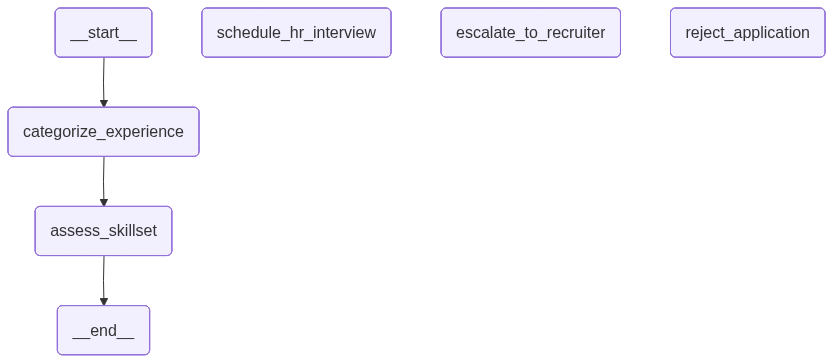

In [5]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
# İş tanımı
job_description = (
    "We are looking for a Python Developer with 5+ years of experience. "
    "Required skills: Python, Django, REST APIs, PostgreSQL, Docker. "
    "Nice to have: AWS, CI/CD, microservices architecture."
)

# --- Senaryo 1: Direkt metin ile ---
application_text = "I have 10 years of experience in software engineering with expertise in JAVA"

# --- Senaryo 2: PDF ile (yorum satırını aç) ---
# cv_text = extract_text_from_pdf("path/to/cv.pdf")

def run_candidate_screening(cv_text: str, job_desc: str):
    results = app.invoke({
        "application": cv_text,
        "cv_text": cv_text,
        "job_description": job_desc
    })
    return results

results = run_candidate_screening(application_text, job_description)

print("\n" + "="*50)
print("SCREENING RESULTS")
print("="*50)
print(f"Application   : {results['application']}")
print(f"Experience    : {results['experience_level']}")
print(f"Skill Match   : {results['skill_match']}")
print(f"Match Score   : {results['match_score']}/100")
print(f"Reasoning     : {results['reasoning']}")
print(f"Decision      : {results['response']}")